In [6]:
#Importing libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
import shap

In [7]:
#Initialize paths to existing data
#
RF_Models='FOREST/MODELS'
X_train_fld='FOREST/X_train'
X_test_fld='FOREST/X_test'
y_train_fld='FOREST/y_train'
y_test_fld='FOREST/y_test'

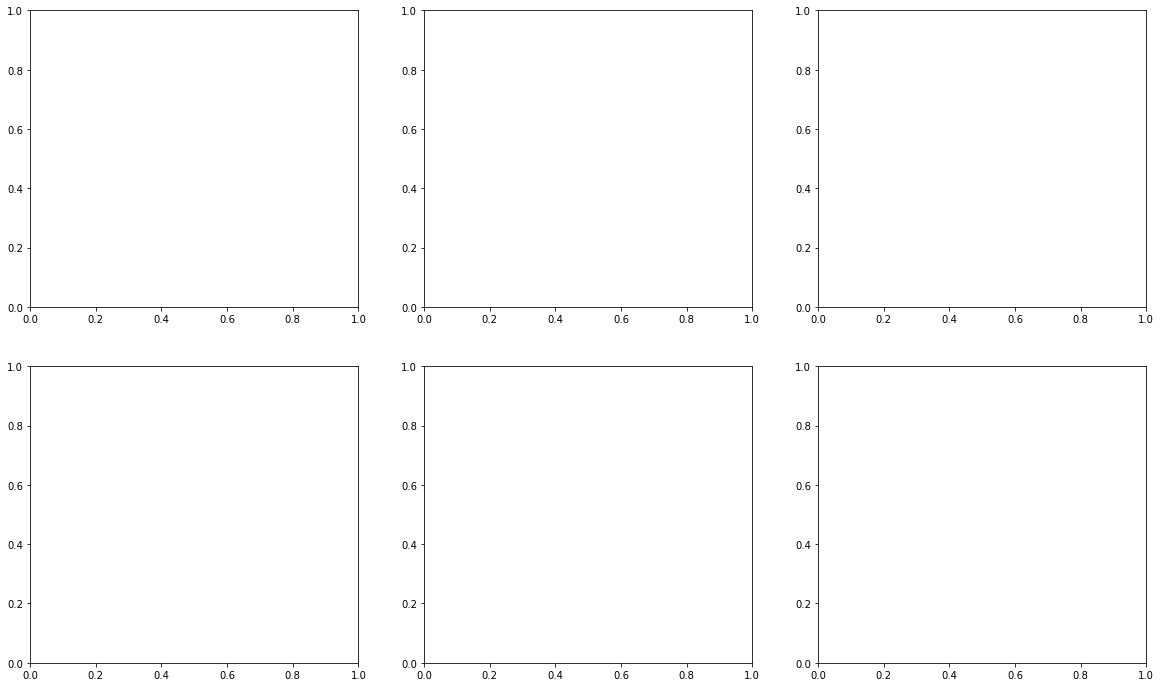

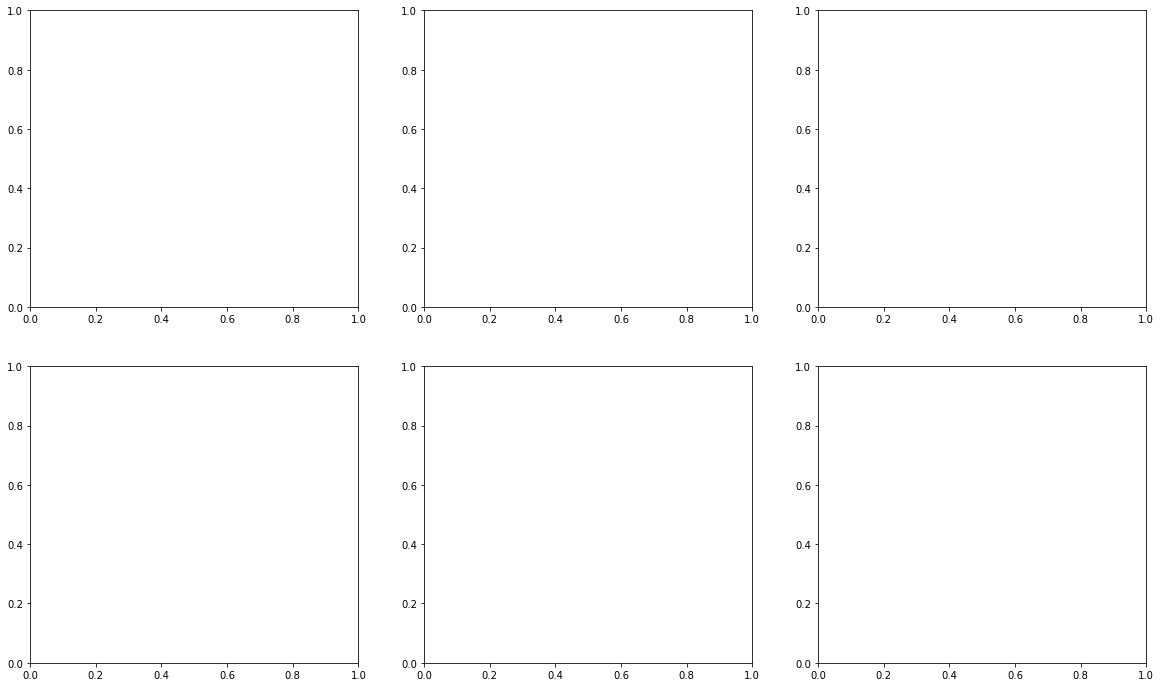

In [8]:
#Defining dfs to gather classification performance and importance from 50 iterations
features=['srt','age', 'num_correct', 'percentage_correct', 'avg_reaction_time', 'total_test_time']
scoring =['accuracy','balanced_accuracy','sensitivity','specificity','precision','f1','roc_auc']
df_fiftyiter_test_results=pd.DataFrame(columns=scoring)
df_fiftyiter_train_results=pd.DataFrame(columns=scoring)
df_coef_rf=pd.DataFrame(columns=features)
df_feat_perm=pd.DataFrame(columns=features)
df_feat_perm_sklearn=pd.DataFrame(columns=features)
df_feature_importance=pd.DataFrame(columns=features)
pdp_iterations_train=[]
pdp_iterations_test=[]


In [9]:
i=1

In [10]:
X_train_feat=pd.read_csv(X_train_fld+'/X_train_it'+str(i)+'.txt', names=features)
X_test_feat=pd.read_csv(X_test_fld+'/X_test_it'+str(i)+'.txt', names=features)
y_train_feat=pd.read_csv(y_train_fld+'/y_train_it'+str(i)+'.txt', names=['hearing_loss'])
y_test_feat=pd.read_csv(y_test_fld+'/y_test_it'+str(i)+'.txt', names=['hearing_loss'])
#load the rf model per each iteration
clf_best=pd.read_pickle(RF_Models+'/Forest_it'+str(i)+'.pkl')
#creating the Pipeline to automate the standarization and classification process
inner_pipe=Pipeline ([('data_prep',StandardScaler()),('clf',clf_best)])
standardtrain=StandardScaler()
standardtest=StandardScaler()


In [11]:
X_train_feat_stdscl=pd.DataFrame(standardtrain.fit_transform(X_train_feat[features]), columns=features)
X_test_feat_stdscl=pd.DataFrame(standardtest.fit_transform(X_test_feat[features]), columns=features)
clf_best.fit(X_train_feat_stdscl,np.ravel(y_train_feat))
y_pred_clf_best_train= clf_best.predict(X_train_feat_stdscl)
y_pred_clf_best_test=clf_best.predict(X_test_feat_stdscl)

In [12]:
#Results change if you previously fit
accuracy_score(y_train_feat,y_pred_clf_best_train)

1.0

In [13]:
accuracy_score(y_test_feat, y_pred_clf_best_test)

0.8837209302325582

In [20]:
comparison_table_train={'index':y_train_feat.index,
                'y_train_feat':y_train_feat['hearing_loss'],
                 'y_pred_clf_best_train':y_pred_clf_best_train,
                 'check':(y_train_feat['hearing_loss']==y_pred_clf_best_train)                 
    }

comparison_table_train_df=pd.DataFrame(data=comparison_table_train)
comparison_table_train_df.to_excel(r'comparison_table_train_df'+str(i)+'.xlsx',index=False)

comparison_table_test={'index':y_test_feat.index,
                'y_test_feat':y_test_feat['hearing_loss'],
                 'y_pred_clf_best_test':y_pred_clf_best_test,
                 'check':(y_test_feat['hearing_loss']==y_pred_clf_best_test)                 
    }

comparison_table_test_df=pd.DataFrame(data=comparison_table_test)
comparison_table_test_df.to_excel(r'comparison_table_test_df'+str(i)+'.xlsx',index=False)
    


### SHAP individual cases with train set

In [14]:
shap.initjs()
explainer_train=shap.explainers.Tree(clf_best, X_train_feat_stdscl)
shap_values_train=explainer_train.shap_values(X_train_feat_stdscl,check_additivity=False)

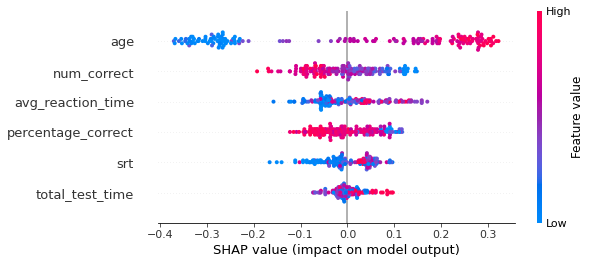

In [15]:
shap.summary_plot(shap_values_train[1], X_train_feat_stdscl[features])

Actual Label: hearing_loss    1
Name: 0, dtype: int64
Predicted Label: 1


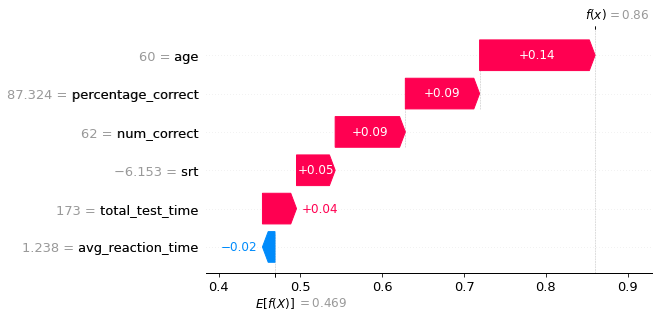

In [16]:
index = 0
print('Actual Label:', y_train_feat.iloc[index])
print('Predicted Label:', y_pred_clf_best_train[index])
shap.plots._waterfall.waterfall_legacy(explainer_train.expected_value[1], shap_values_train[1][index,:], features=X_train_feat[features].iloc[index,:], feature_names=features)

Actual Label: hearing_loss    0
Name: 2, dtype: int64
Predicted Label: 0


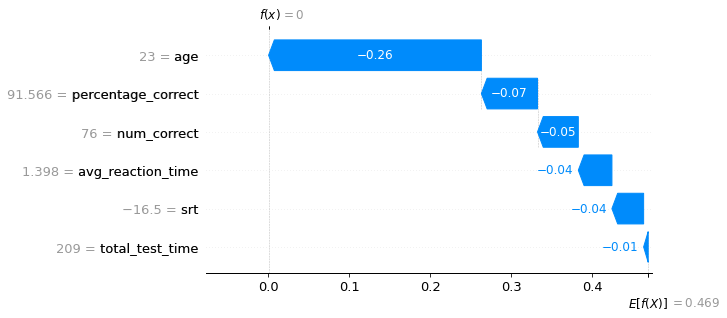

In [17]:
index = 2
print('Actual Label:', y_train_feat.iloc[index])
print('Predicted Label:', y_pred_clf_best_train[index])
shap.plots._waterfall.waterfall_legacy(explainer_train.expected_value[1], shap_values_train[1][index,:], features=X_train_feat[features].iloc[index,:], feature_names=features)

### SHAP individual cases with test set

In [19]:
shap.initjs()
explainer_test=shap.explainers.Tree(clf_best, X_test_feat_stdscl)
shap_values_test=explainer_test.shap_values(X_test_feat_stdscl,check_additivity=False)

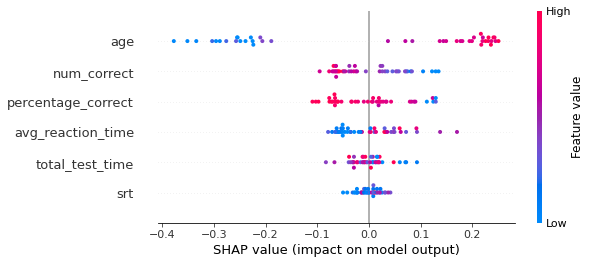

In [57]:
shap.summary_plot(shap_values_test[1], X_test_feat_stdscl[features])

Actual Label: hearing_loss    0
Name: 4, dtype: int64
Predicted Label: 0


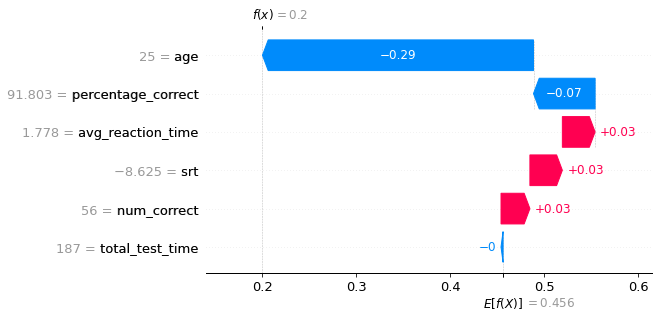

In [23]:
index = 4
print('Actual Label:', y_test_feat.iloc[index])
print('Predicted Label:', y_pred_clf_best_test[index])
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test[1][index,:], features=X_test_feat[features].iloc[index,:], feature_names=features)

Actual Label: hearing_loss    1
Name: 3, dtype: int64
Predicted Label: 1


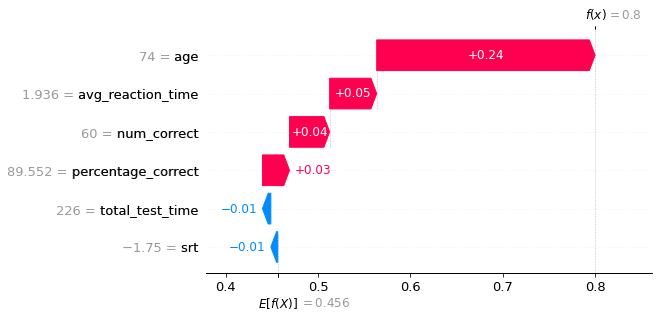

In [34]:
index = 3
print('Actual Label:', y_test_feat.iloc[index])
print('Predicted Label:', y_pred_clf_best_test[index])
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test[1][index,:], features=X_test_feat[features].iloc[index,:], feature_names=features)

Actual Label: hearing_loss    1
Name: 0, dtype: int64
Predicted Label: 0


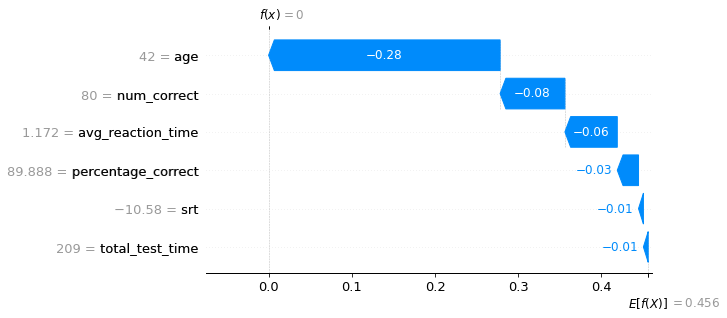

In [36]:
index = 0
print('Actual Label:', y_test_feat.iloc[index])
print('Predicted Label:', y_pred_clf_best_test[index])
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test[1][index,:], features=X_test_feat[features].iloc[index,:], feature_names=features)

Actual Label: hearing_loss    0
Name: 31, dtype: int64
Predicted Label: 1


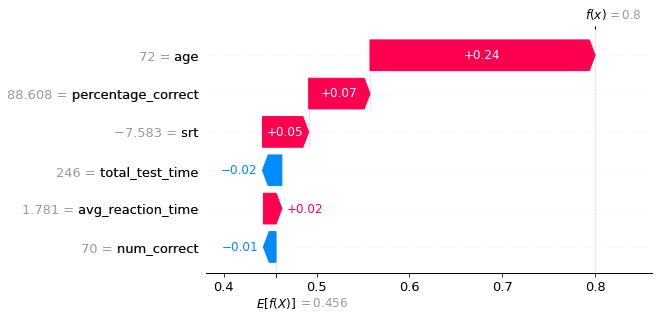

In [33]:
index = 31
print('Actual Label:', y_test_feat.iloc[index])
print('Predicted Label:', y_pred_clf_best_test[index])
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test[1][index,:], features=X_test_feat[features].iloc[index,:], feature_names=features)